In [1]:
import json
import sys
import os
from PIL import Image, ImageDraw

In [2]:
# import the library
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(root_dir)

from svglib.svg import SVG
from svglib.geom import Point

In [3]:
sample_dir = os.path.join(root_dir, "samples")
coords = json.load(open(os.path.join(sample_dir, "placing.json")))  # a file that tells you where to place a series of SVGs in a canvas 

## draw the destination bounding boxes on a raster image
This gives us an idea of where to place all the SVGs 

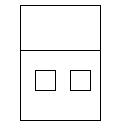

In [ ]:

img = Image.new('RGB', (128, 128), color='white')
draw = ImageDraw.Draw(img)
for _, c in coords.items():
    x, y, x2, y2 = c['bounding_box']
    draw.rectangle([x, y, x2, y2], outline="black", fill=None)
img

## Compute the scaling between the target bounding box and the original shape
By defaul we consider the full size of each original shape (128, 128)

In [17]:
# let's take the first square, and scale it to fit its bounding box in the canvas
def compute_scale(x1, y1, x2, y2, orig_w=128, orig_h=128):
    new_w, new_h = (x2 - x1, y2 - y1)  # the size of the bounding box
    width_ratio = new_w / orig_w
    height_ratio = new_h / orig_h
    return width_ratio, height_ratio

(x1, y1, x2, y2) = coords["house_body"]["bounding_box"]
width_ratio, height_ratio = compute_scale(x1, y1, x2, y2)
print(width_ratio, height_ratio)
scale_factor = min(width_ratio, height_ratio)


0.625 0.546875


## display one SVG

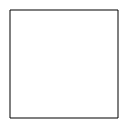

SVG[Bbox(0.0 0.0 128.0 128.0)](
	SVGLine(xy1=P(10.0, 10.0) xy2=P(118.0, 10.0)),
	SVGLine(xy1=P(118.0, 10.0) xy2=P(118.0, 118.0)),
	SVGLine(xy1=P(118.0, 118.0) xy2=P(10.0, 118.0)),
	SVGLine(xy1=P(10.0, 118.0) xy2=P(10.0, 10.0))
)

In [ ]:
svg_path = os.path.join(sample_dir, coords["house_body"]["file"])
svg = SVG.load_svg(svg_path)
svg.draw(do_display=True)
svg

## Let's scale and translate the shape
This uses the the minimum scale factor between X and Y wrt the target bounding box!

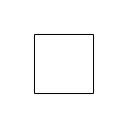

In [ ]:
# scaling
svg.scale(scale_factor)
svg.draw(do_display=True)


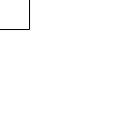

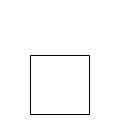

In [8]:
# let's adjust the shape so that the new center is the center of the bounding box
svg.translate(-svg.viewbox.center)
svg.draw(do_display=True)

target_center = Point((x1 + x2) // 2, (y1 + y2) // 2)
svg.translate(target_center)
svg.draw(do_display=True)


## Apply this to all the basic shapes and their bounding boxes, then composite!

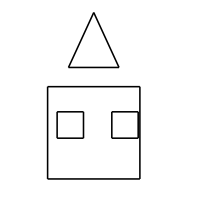

In [9]:
# apply this to every shape in the SVG file
composite = SVG([], (128, 128), width=128, height=128)

for shape in coords.values():
    svg_path = os.path.join(sample_dir, shape["file"])
    svg = SVG.load_svg(svg_path)
    
    (x1, y1, x2, y2) = shape["bounding_box"]
    width_ratio, height_ratio = compute_scale(x1, y1, x2, y2)
    scale_factor = min(width_ratio, height_ratio)
    target_center = Point((x1 + x2) // 2, (y1 + y2) // 2)
    
    svg.scale(scale_factor)
    svg.translate(-svg.viewbox.center)
    svg.translate(target_center)
    composite = composite + svg 
    
composite.draw(do_display=True)

## Not nice. Use (sx, sy) to scale

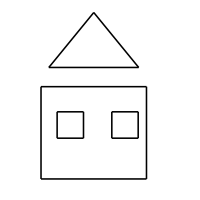

In [10]:
composite = SVG([], (128, 128), width=128, height=128)
for shape in coords.values():
    svg_path = os.path.join(sample_dir, shape["file"])
    svg = SVG.load_svg(svg_path)
    
    (x1, y1, x2, y2) = shape["bounding_box"]
    width_ratio, height_ratio = compute_scale(x1, y1, x2, y2)
    target_center = Point((x1 + x2) // 2, (y1 + y2) // 2)
    
    svg.scale((width_ratio, height_ratio))
    svg.translate(-svg.viewbox.center)
    svg.translate(target_center)
    composite = composite + svg 
    
composite.draw(do_display=True)

## We inherit the padding of the original image
Let's use the bounding boxes that wrap each basic shape to compute the best scaling ratio

In [ ]:
svg.bbox()

((31.25, 8.015625), (88.75, 43.171875))

P(60.0, 85.0)
P(45.0, 80.0)
P(80.0, 80.0)
P(60.0, 27.0)


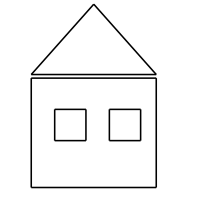

In [ ]:

composite = SVG([], (128, 128), width=128, height=128)

for shape in coords.values():
    svg_path = os.path.join(sample_dir, shape["file"])
    svg = SVG.load_svg(svg_path)
    
    (x1, y1, x2, y2) = shape["bounding_box"]
    (_x1, _y1), (_x2, _y2) = svg.bbox()
    
    # compute width and height for the box rather than the full image
    _w, _h = _x2 - _x1, _y2 - _y1
    width_ratio, height_ratio = compute_scale(x1, y1, x2, y2, _w, _h)

    target_center = Point((x1 + x2) // 2, (y1 + y2) // 2)
    
    svg.scale((width_ratio, height_ratio))
    svg.translate(-svg.viewbox.center)
    svg.translate(target_center)
    composite = composite + svg 
    
composite.draw(do_display=True)

In [14]:
target_center

P(64.0, 60.0)